In [1]:
import datetime
from dateutil.relativedelta import relativedelta
#from datetime import timedelta
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns


import plotly
import chart_studio.plotly as py
import plotly.io as pio
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot


import json
from flask import Flask, render_template

import dash
import dash_html_components as html

In [2]:
pd.set_option('display.max_rows', 1000)
pio.templates.default = "plotly_dark"

In [3]:
df = pd.read_csv('./data/NRFDailySalesBuys_v3.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
df['Store_Date'] = pd.to_datetime(df['Store_Date'])

In [5]:
# filt_today = df['Store_Date'] == '03/12/2020'
# df.drop(df[filt_today].index, axis=0, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90207 entries, 0 to 90206
Data columns (total 32 columns):
DistrictName                       90207 non-null object
LocationNo                         90207 non-null object
Store_Date                         90207 non-null datetime64[ns]
NRF_Year                           90207 non-null int64
NRF_Week_Restated                  90207 non-null int64
NRF_Day                            90207 non-null int64
sales_CountTransactions            89530 non-null float64
sales_AmtSold                      89530 non-null float64
sales_AmtSold_Frontline            89392 non-null float64
sales_AmtSold_New                  89528 non-null float64
sales_AmtSold_Used                 89529 non-null float64
sales_QtySold                      89530 non-null float64
sales_QtySold_Frontline            89392 non-null float64
sales_QtySold_New                  89528 non-null float64
sales_QtySold_Used                 89529 non-null float64
buys_CountTransactions

In [7]:
calcColumns = [c for c in df.columns if c not in ['DistrictName', 'LocationNo', 'Store_Date', 'NRF_Year', 'NRF_Week_Restated', 'NRF_Day']]
df.dropna(inplace=True)

In [91]:
    rollGroupColumns = ['DistrictName', 'LocationNo']
    idxColumns = ['DistrictName', 'LocationNo', 'Store_Date', 'NRF_Year', 'NRF_Week_Restated', 'NRF_Day']
    remColumns = [c for c in df.columns if c[0:7] == 'rollavg']
    calcColumns = [c for c in df.columns if c not in (idxColumns + remColumns)]
    df_r = df.groupby(rollGroupColumns).rolling(4*7, on='Store_Date')[calcColumns].mean().dropna(how='all')

In [92]:
idxColumns + remColumns

['DistrictName',
 'LocationNo',
 'Store_Date',
 'NRF_Year',
 'NRF_Week_Restated',
 'NRF_Day',
 'rollavg_sales_CountTransactions',
 'rollavg_sales_AmtSold',
 'rollavg_sales_AmtSold_Frontline',
 'rollavg_sales_AmtSold_New',
 'rollavg_sales_AmtSold_Used',
 'rollavg_sales_QtySold',
 'rollavg_sales_QtySold_Frontline',
 'rollavg_sales_QtySold_New',
 'rollavg_sales_QtySold_Used',
 'rollavg_buys_CountTransactions',
 'rollavg_buys_AmtPurchased',
 'rollavg_buys_QtyPurchased',
 'rollavg_buys_BuyWaitSeconds']

In [ ]:
def createDFRollAvgs(df, window):
    rollGroupColumns = ['DistrictName', 'LocationNo']
    idxColumns = ['DistrictName', 'LocationNo', 'Store_Date', 'NRF_Year', 'NRF_Week_Restated', 'NRF_Day']
    remColumns = [c for c in df.columns if c[0:7] == 'rollavg']
    calcColumns = [c for c in df.columns if c not in (idxColumns + remColumns)]
    df_r = df.groupby(rollGroupColumns).rolling(4*7, on='Store_Date')[calcColumns].mean().dropna(how='all')

In [48]:
def compDistrict(df, districtName, yearCurr, yearPrev):
    idxColumns = ['DistrictName', 'Store_Date', 'NRF_Year', 'NRF_Week_Restated', 'NRF_Day']
    calcColumns = [c for c in df.columns if c not in idxColumns + ['LocationNo']]
    df_District = df.drop('LocationNo', axis=1).groupby(idxColumns).sum().reset_index()
    
    filt_yearCurr = df_District['NRF_Year'] == yearCurr
    filt_yearPrev = df_District['NRF_Year'] == yearPrev
    filt_District = df_District['DistrictName'] == districtName
    
    df_DistrictTY = df_District[filt_District & filt_yearCurr].set_index('NRF_Day', drop=True)
    df_DistrictLY = df_District[filt_District & filt_yearPrev].set_index('NRF_Day', drop=True)
    
    df_compDistrict = df_DistrictTY.join(df_DistrictLY['Store_Date'], rsuffix='_LY')
    df_compDistrict[calcColumns] = df_DistrictTY[calcColumns].divide(df_DistrictLY[calcColumns])
    
    return df_compDistrict.reset_index()

def compChain(df, yearCurr, yearPrev):
    idxColumns = ['LocationNo', 'DistrictName', 'Store_Date', 'NRF_Year', 'NRF_Week_Restated', 'NRF_Day']
    calcColumns = [c for c in df.columns if c not in idxColumns]
    filt_Chain = df['LocationNo'] == 'Chain'
    filt_yearCurr = df['NRF_Year'] == yearCurr
    filt_yearPrev = df['NRF_Year'] == yearPrev
    
    df_ChainTY = df[filt_Chain & filt_yearCurr].set_index('NRF_Day', drop=True)
    df_ChainLY = df[filt_Chain & filt_yearPrev].set_index('NRF_Day', drop=True)
    
    df_compChain = df_ChainTY.join(df_ChainLY['Store_Date'], rsuffix='_LY')
    df_compChain[calcColumns] = df_ChainTY[calcColumns].divide(df_ChainLY[calcColumns])
    
    return df_compChain.reset_index()

def compChainWeeks(df, yearCurr, yearPrev):
    idxColumns = ['LocationNo', 'DistrictName', 'Store_Date', 'NRF_Week_Restated','NRF_Year', 'NRF_Day']
    calcColumns = [c for c in df.columns if c not in idxColumns]
    filt_Chain = df['LocationNo'] == 'Chain'
    filt_yearCurr = df['NRF_Year'] == yearCurr
    filt_yearPrev = df['NRF_Year'] == yearPrev
    
    df_ChainTY = df[filt_Chain & filt_yearCurr].groupby('NRF_Week_Restated')[calcColumns].sum()
    df_ChainLY = df[filt_Chain & filt_yearPrev].groupby('NRF_Week_Restated')[calcColumns].sum()
    df_StartOfWeek = df[filt_Chain & filt_yearCurr].groupby('NRF_Week_Restated')['Store_Date'].min()
    
    df_compChain = df_ChainTY.join(df_StartOfWeek).join(df['Store_Date'], rsuffix='_LY')
    df_compChain[calcColumns] = df_ChainTY[calcColumns].divide(df_ChainLY[calcColumns])
    
    return df_compChain.reset_index()

In [49]:
df_2020_WA_District = compDistrict(df, 'Washington', 2020, 2019)

In [50]:
df_2020_Chain = compChain(df, 2020, 2019)

In [51]:
df_2020_Chain_Weeks = compChainWeeks(df, 2020, 2019)

In [52]:
df_2020_Chain_Weeks

,NRF_Week_Restated,sales_CountTransactions,sales_AmtSold,sales_AmtSold_Frontline,sales_AmtSold_New,sales_AmtSold_Used,sales_QtySold,sales_QtySold_Frontline,sales_QtySold_New,sales_QtySold_Used,...,rollavg_sales_QtySold,rollavg_sales_QtySold_Frontline,rollavg_sales_QtySold_New,rollavg_sales_QtySold_Used,rollavg_buys_CountTransactions,rollavg_buys_AmtPurchased,rollavg_buys_QtyPurchased,rollavg_buys_BuyWaitSeconds,Store_Date,Store_Date_LY
0,1,0.991629,1.006237,0.579999,1.262954,0.987053,0.986157,0.525862,1.192982,0.956913,...,0.968992,0.482759,1.164029,0.943486,0.915789,0.910256,0.912057,0.887065,2020-02-03,2018-02-06
1,2,0.997205,1.016372,0.604960,1.271869,0.997802,1.004514,0.554054,1.184615,0.981258,...,0.988619,0.500000,1.182033,0.962497,0.942652,0.935263,0.941850,0.948717,2020-02-10,2018-02-07
2,3,0.990105,1.005608,0.646344,1.256100,0.979479,0.988966,0.606838,1.149239,0.964674,...,0.990295,0.536000,1.176784,0.965260,0.948454,0.931292,0.941736,0.924853,2020-02-17,2018-02-08
3,4,0.970195,0.990358,0.626728,1.237127,0.965508,0.972072,0.601770,1.116989,0.950919,...,0.988951,0.547009,1.169346,0.964617,0.955631,0.939367,0.948737,0.930576,2020-02-24,2018-02-09
4,5,0.987730,1.003105,0.639106,1.281262,0.973051,1.018663,0.615385,1.240161,0.981592,...,0.992985,0.560345,1.172996,0.967763,0.962199,0.945440,0.952409,0.942355,2020-03-02,2018-02-10
5,6,0.847231,0.893347,0.642123,1.119883,0.872188,0.868266,0.589286,1.019763,0.846720,...,0.978576,0.579365,1.154618,0.952858,0.939597,0.927068,0.932586,0.926202,2020-03-09,2018-02-11


In [53]:
df_2020_Chain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 33 columns):
NRF_Day                            42 non-null int64
DistrictName                       42 non-null object
LocationNo                         42 non-null object
Store_Date                         42 non-null datetime64[ns]
NRF_Year                           42 non-null int64
NRF_Week_Restated                  42 non-null int64
sales_CountTransactions            42 non-null float64
sales_AmtSold                      42 non-null float64
sales_AmtSold_Frontline            42 non-null float64
sales_AmtSold_New                  42 non-null float64
sales_AmtSold_Used                 42 non-null float64
sales_QtySold                      42 non-null float64
sales_QtySold_Frontline            42 non-null float64
sales_QtySold_New                  42 non-null float64
sales_QtySold_Used                 42 non-null float64
buys_CountTransactions             42 non-null float64
buys_AmtPurchased 

In [54]:
def create_palette(int_NumColors, str_PaletteName, list_ColorLocs):
    #sns.color_palette('icefire', n_colors=64).as_hex()
    list_PaletteColors = sns.color_palette(str_PaletteName, n_colors=int_NumColors).as_hex()
    sns.palplot(list_PaletteColors)
    list_HexColors = []
    for c in list_ColorLocs:
        list_HexColors.append(list_PaletteColors[c])
    return list_HexColors

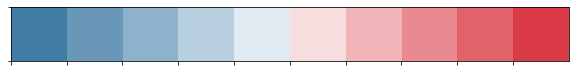

In [55]:
sns.palplot(sns.diverging_palette(240, 10, n=10))

In [67]:
list_Colors = create_palette(10, 'RdYlBu', np.arange(0,10))

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    specs=[[{"type": "bar"}],
           [{"type": "table"}]]
)


trace1 = fig.add_trace(go.Bar(
    x=df_2020_Chain['Store_Date'],
    y=df_2020_Chain['sales_CountTransactions'] - 1,
    marker=dict(color=list_Colors[7]),
    opacity = 0.75,
    name = 'Actual Value'
    ),
    row = 1, col = 1)

trace2 = go.Scatter(
    x=df_2020_Chain['Store_Date'],
    y=df_2020_Chain['rollavg_sales_CountTransactions'] - 1,
    marker=dict(color=list_Colors[2]),#color='#cc6600'),
    name = '52wk Rolling Average'
    )
#data=[trace1, trace2]
fig.add_trace()
layout = go.Layout(    
                title=go.layout.Title(
                        text='NRF 2020 Chain-wide Sales Transaction Count',
                        xref='paper',
                        x=0,
                        xanchor='left'),
                legend=dict(x=1.1, y=.5, xanchor='left', yanchor='middle'),
                width=800,
                height=400,
                margin=go.layout.Margin(
                    l=100,
                    r=100,
                    b=100,
                    t=100,
                    pad=10,
                    autoexpand=True),
                xaxis=dict(type='date',
                           tickfont=dict(family='Arial, san-serif', size=10),
                           tickangle=90,
                           tickformat = '%Y-%m-%d'),
                yaxis=dict(title='Percent Difference',
                           titlefont=dict(family='Arial, san-serif', size=11),
                           tickfont=dict(family='Arial, san-serif', size=10),
                           tickformat = '0.2%'),
                barmode='group',
                bargap=0.4,
                bargroupgap=0)
fig.update_layout(layout)

iplot(fig)

SyntaxError: invalid syntax (<ipython-input-67-8d3c311a9fba>, line 19)

In [57]:
df_comp.columns

Index(['DistrictName', 'LocationNo', 'Store_Date', 'NRF_Year',
       'NRF_Week_Restated', 'sales_CountTransactions', 'sales_AmtSold',
       'sales_AmtSold_Frontline', 'sales_AmtSold_New', 'sales_AmtSold_Used',
       'sales_QtySold', 'sales_QtySold_Frontline', 'sales_QtySold_New',
       'sales_QtySold_Used', 'buys_CountTransactions', 'buys_AmtPurchased',
       'buys_QtyPurchased', 'buys_BuyWaitSeconds',
       'rollavg_sales_CountTransactions', 'rollavg_sales_AmtSold',
       'rollavg_sales_AmtSold_Frontline', 'rollavg_sales_AmtSold_New',
       'rollavg_sales_AmtSold_Used', 'rollavg_sales_QtySold',
       'rollavg_sales_QtySold_Frontline', 'rollavg_sales_QtySold_New',
       'rollavg_sales_QtySold_Used', 'rollavg_buys_CountTransactions',
       'rollavg_buys_AmtPurchased', 'rollavg_buys_QtyPurchased',
       'rollavg_buys_BuyWaitSeconds', 'Store_Date_LY'],
      dtype='object')

In [97]:
#list_Colors = create_palette(10, '', np.arange(0,10))
traceDailyActual = go.Bar(
    x=df_2020_Chain['Store_Date'],
    y=df_2020_Chain['sales_AmtSold'] - 1,
    marker=dict(color=list_Colors[8]),
    opacity = 0.75,
    name = 'Actual Value'
    )

trace52wkRoll = go.Scatter(
    x=df_2020_Chain['Store_Date'],
    y=df_2020_Chain['sales_AmtSold_4wkRollAvg'] - 1,
    marker=dict(color=list_Colors[2]),#)list_Colors[9]),#color='#cc6600'),
    name = '4wk Rolling Average'
    )

traceTable = go.Table(
        header=dict(
            values=["Date TY", "Sales Transactions", "Total Sales Amt TY", "Comp Date LY", "Pct Diff<br>Sales Transactions", "Pct Diff Total Sales"],
            font=dict(size=10),
            align="left"
        ),
        cells=dict(
            values=[df[k].tolist() for k in df.columns[1:]],
            align = "left")
)

data=[traceDailyActual, trace52wkRoll, ]

layout = go.Layout(    
                title=go.layout.Title(
                        text='NRF 2020 Chain-wide Sales Amount',
                        xref='paper',
                        x=0,
                        xanchor='left'),
                legend=dict(x=1.1, y=.5, xanchor='left', yanchor='middle'),
                width=800,
                height=400,
                margin=go.layout.Margin(
                    l=100,
                    r=100,
                    b=100,
                    t=100,
                    pad=10,
                    autoexpand=True),
                xaxis=dict(type='date',
                           tickfont=dict(family='Arial, san-serif', size=10),
                           tickangle=90,
                           tickformat = '%Y-%m-%d'),
                yaxis=dict(title='Percent Difference',
                           titlefont=dict(family='Arial, san-serif', size=11),
                           tickfont=dict(family='Arial, san-serif', size=10),
                           tickformat = '0.2%'),
                barmode='group',
                bargap=0.4,
                bargroupgap=0)
fig = go.FigureWidget(data=data, layout=layout)

iplot(fig)

KeyError: 'sales_AmtSold_4wkRollAvg'

In [62]:
filt_Dates = df_2020_Chain_Weeks['NRF_Week_Restated'] < 7
df_2020_Chain_Weeks[filt_Dates]['Store_Date']

0   2020-02-03
1   2020-02-10
2   2020-02-17
3   2020-02-24
4   2020-03-02
5   2020-03-09
Name: Store_Date, dtype: datetime64[ns]

In [63]:
filt_Dates = df_2020_Chain_Weeks['NRF_Week_Restated'] < df_2020_Chain_Weeks['NRF_Week_Restated'].max()
trace1 = go.Bar(
    x=df_2020_Chain_Weeks[filt_Dates]['Store_Date'],
    y=df_2020_Chain_Weeks[filt_Dates]['sales_CountTransactions'] - 1,
    marker=dict(color=list_Colors[0]),
    name = 'Actual Value'
    )

trace2 = go.Scatter(
    x=df_2020_Chain_Weeks[filt_Dates]['Store_Date'],
    y=df_2020_Chain_Weeks[filt_Dates]['rollavg_sales_AmtSold'] - 1,
    marker=dict(color=list_Colors[2]),#)list_Colors[9]),#color='#cc6600'),
    name = '12mo Rolling Average'
    )
data=[trace1]

layout = go.Layout(    
                title=go.layout.Title(
                        text='NRF 2020 Chain-wide Sales Transaction Count',
                        xref='paper',
                        x=0,
                        xanchor='left'),
                legend=dict(x=1.1, y=.5, xanchor='left', yanchor='middle'),
                width=800,
                height=400,
                margin=go.layout.Margin(
                    l=100,
                    r=100,
                    b=100,
                    t=100,
                    pad=10,
                    autoexpand=True),
                xaxis=dict(type='date',
                           tickfont=dict(family='Arial, san-serif', size=10),
                           tickangle=90,
                           tickformat = '%Y-%m-%d'),
                yaxis=dict(title='Percent Difference',
                           titlefont=dict(family='Arial, san-serif', size=11),
                           tickfont=dict(family='Arial, san-serif', size=10),
                           tickformat = '0.2%'),
                barmode='group',
                bargap=0.4,
                bargroupgap=0)
fig = go.FigureWidget(data=data, layout=layout)

iplot(fig)

In [64]:
filt_Dates = df_2020_Chain_Weeks['NRF_Week_Restated'] < 7
trace1 = go.Bar(
    x=df_2020_Chain_Weeks[filt_Dates]['Store_Date'],
    y=df_2020_Chain_Weeks[filt_Dates]['sales_AmtSold'] - 1,
    marker=dict(color=list_Colors[1]),
    name = 'Actual Value'
    )

trace2 = go.Scatter(
    x=df_2020_Chain_Weeks[filt_Dates]['Store_Date'],
    y=df_2020_Chain_Weeks[filt_Dates]['rollavg_sales_AmtSold'] - 1,
    marker=dict(color=list_Colors[2]),#)list_Colors[9]),#color='#cc6600'),
    name = '12mo Rolling Average'
    )
data=[trace1]

layout = go.Layout(    
                title=go.layout.Title(
                        text='NRF 2020 Chain-wide Sales Amount',
                        xref='paper',
                        x=0,
                        xanchor='left'),
                legend=dict(x=1.1, y=.5, xanchor='left', yanchor='middle'),
                width=800,
                height=400,
                margin=go.layout.Margin(
                    l=100,
                    r=100,
                    b=100,
                    t=100,
                    pad=10,
                    autoexpand=True),
                xaxis=dict(type='date',
                           tickfont=dict(family='Arial, san-serif', size=10),
                           tickangle=90,
                           tickformat = '%Y-%m-%d'),
                yaxis=dict(title='Percent Difference',
                           titlefont=dict(family='Arial, san-serif', size=11),
                           tickfont=dict(family='Arial, san-serif', size=10),
                           tickformat = '0.2%'),
                barmode='group',
                bargap=0.4,
                bargroupgap=0)
fig = go.FigureWidget(data=data, layout=layout)

iplot(fig)

In [66]:
filt_Date = df_2020_WA_District['Store_Date'] >= '2/16/2020'
trace1 = go.Bar(
    x=df_2020_WA_District[filt_Date]['Store_Date'],
    y=df_2020_WA_District[filt_Date]['sales_AmtSold'] - 1,
    marker=dict(color=list_Colors[7]),
    opacity = 0.75,
    name = 'Actual Value'
    )

trace2 = go.Scatter(
    x=df_2020_WA_District[filt_Date]['Store_Date'],
    y=df_2020_WA_District[filt_Date]['rollavg_sales_AmtSold'] - 1,
    marker=dict(color=list_Colors[2]),#color='#cc6600'),
    name = '12mo Rolling Average'
    )
data=[trace1, trace2]

layout = go.Layout(    
                title=go.layout.Title(
                        text='2020 NRF Washington Sales Amount',
                        xref='paper',
                        x=0,
                        xanchor='left'),
                legend=dict(x=1.1, y=.5, xanchor='left', yanchor='middle'),
                width=800,
                height=400,
                margin=go.layout.Margin(
                    l=100,
                    r=100,
                    b=100,
                    t=100,
                    pad=10,
                    autoexpand=True),
                xaxis=dict(type='date',
                           tickfont=dict(family='Arial, san-serif', size=10),
                           tickangle=90,
                           tickformat = '%Y-%m-%d'),
                yaxis=dict(title='Percent Difference',
                           titlefont=dict(family='Arial, san-serif', size=11),
                           tickfont=dict(family='Arial, san-serif', size=10),
                           tickformat = '0.2%'),
                barmode='group',
                bargap=0.4,
                bargroupgap=0)
fig = go.FigureWidget(data=data, layout=layout)

iplot(fig)